In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_absolute_error as mae, mean_squared_error as mse, r2_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from scipy.stats import norm, probplot
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from scipy.special import boxcox1p, inv_boxcox, inv_boxcox1p

from xgboost import XGBRegressor

import seaborn as sns
import matplotlib.pyplot as plt

import winsound
import time

In [3]:
duration = 5000  # milliseconds
freq = 440  # Hz

#### Função para calcular o score do no modelo

In [4]:
def rmse(y_true, preds):
    return mse(y_true, preds, squared=False)
    
def score_(X_train, X_valid, y_train, y_valid, model = LinearRegression(n_jobs=5)):
    '''
    Score model with root mean squared error (RMSE)
    '''
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return rmse(y_valid, preds)
#     return mae(y_valid, preds)

In [5]:
# carregando o dataset, a extração é do dataset disponível em: https://www.kaggle.com/datasets/argonalyst/sao-paulo-real-estate-sale-rent-april-2019?resource=download
# Lembrando que também conseguimos utilizar o algoritmo de extração direto de sistemas de alguel.

In [6]:
df = pd.read_csv('data/sao-paulo-properties-april-2019.csv')
df.head(3)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665


In [7]:
df[['District', 'City']] = df.District.str.split('/', expand=True)

Price - Valor do imóvel em Reais (BRL)

Condo - Custo do condomínio em Reais (BRL)

Size - Area do imóvel em metros quadrados M²

Rooms - Número de quartos

Toilets - Total de banheiros

Suites - Total de quartos com banheiros

Parking - Número de vagas de estacionamento

Elevator - Valor binário se existe elevador

Furnished- Se o imóvel é ou não mobiliado

Swimming Pool - Existe ou não piscina

New = Imóvel é novo

District - Bairro e cidade onde o imóvel está localizado

Negotiation Type - Tipo de necociação (aluguel, venda...)

Property Type - Tipo de imóvel (apartamento, casa)

Latitude - posição geográfica

Longitude - posição geográfica

City - Cidade

## Vamos filtrar os campos, pois queremos apenas registro para `aluguel`, e tipo do imóvel como `apartamento`

In [9]:
df['Negotiation Type'].value_counts().to_frame()

,Negotiation Type
rent,7228
sale,6412


In [72]:
df = df[df['Negotiation Type'] == 'rent']

In [10]:
df['Property Type'].value_counts().to_frame()

,Property Type
apartment,13640


## Quais são os dados nulos?

In [13]:
df.isna().sum().sort_values().to_frame().rename({0: 'Quantidade Nulos'}, axis=1)

,Quantidade Nulos
Price,0
Latitude,0
Property Type,0
Negotiation Type,0
District,0
New,0
Swimming Pool,0
Longitude,0
Furnished,0
Parking,0


# Quantos bairros tempos?

In [17]:
print(f"Temos: {df['District'].nunique()} bairros na base")

Temos: 96 bairros na base


# Quais os bairros com mais mais disponibilidade?

In [19]:
df['District'].value_counts().sort_values(ascending=False).to_frame().rename({'District':'Quantidade'}, axis=1).head(10)

,Quantidade
Moema,293
Mooca,288
Brás,255
Brooklin,250
Bela Vista,250
Pinheiros,249
Casa Verde,248
Cambuci,241
Perdizes,236
Alto de Pinheiros,230


### Qual a média de cada bairro?

In [20]:
df.groupby(['District'], as_index=False).Price.median().sort_values(by='Price', ascending=False)

,District,Price
9,Brooklin,562570.0
54,Pari,380000.0
7,Bom Retiro,369000.0
73,São Domingos,369000.0
20,Casa Verde,360000.0
...,...,...
28,Freguesia do Ó,1700.0
8,Brasilândia,1525.0
48,Limão,1500.0
12,Cachoeirinha,1400.0


Vamos pegar uma amostra de valores aleatórios no dataframe.

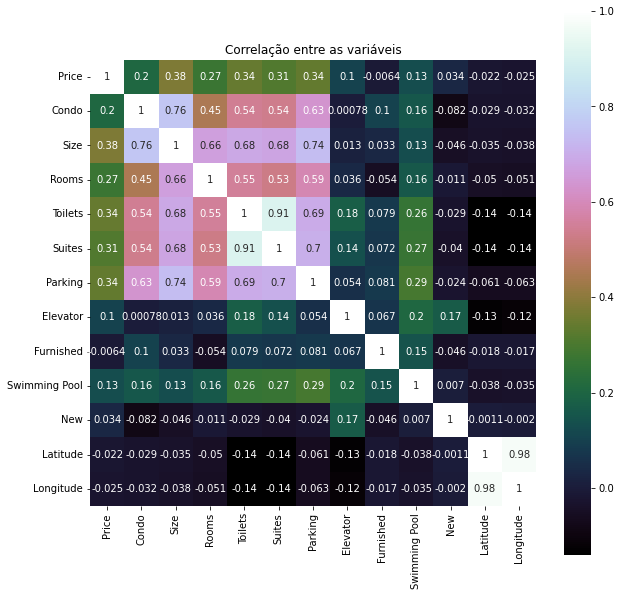

In [21]:
correlation = df.corr()
plt.figure(figsize=(10,10))
plt.title('Correlação entre as variáveis')
sns.heatmap(correlation, square=True,annot=True,cmap='cubehelix')
plt.show()

Podemos perceber que `suites` tem correlação muito alta com `Toilets`

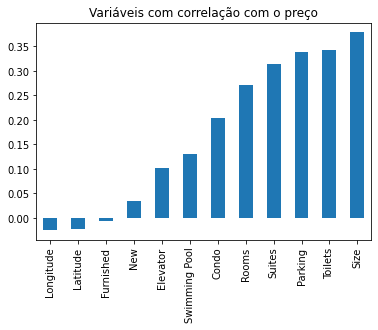

In [43]:
plt.title('Variáveis com correlação com o preço')
price_corr = correlation.Price.sort_values()
price_corr[price_corr.index[0:-1]].plot.bar()
plt.show()

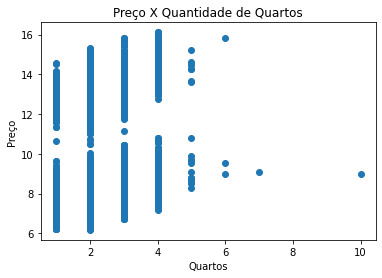

In [44]:
fig, ax= plt.subplots()
ax.scatter(x=df['Rooms'], y=np.log(df['Price']))
plt.ylabel('Preço')
plt.xlabel('Quartos')
plt.title("Preço X Quantidade de Quartos")
plt.show()

In [45]:
df = df[(df.Price <= 20000) & (df.Rooms <= 5)]

Vamos guardar 10 registros de amostra para validar nosso modelo 

In [88]:
test_sample = df.sample(20)
df = df.drop(test_sample.index).reset_index(drop=True)

c:\python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


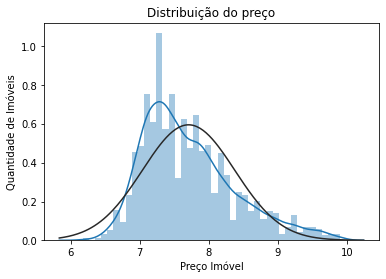

In [89]:
sns.distplot(df.Price, fit=norm)
plt.xlabel('Preço Imóvel')
plt.ylabel('Quantidade de Imóveis')
plt.title('Distribuição do preço')
plt.show()

Vamos ajustar o preço para uma distribuição `normal`

c:\python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


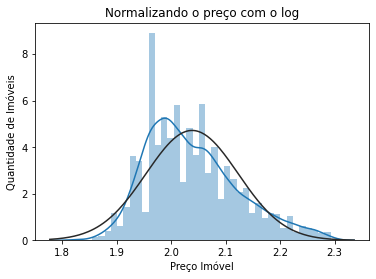

In [90]:
sns.distplot(np.log(df.Price), fit=norm)
plt.xlabel('Preço Imóvel')
plt.ylabel('Quantidade de Imóveis')
plt.title('Normalizando o preço com o log')
plt.show()

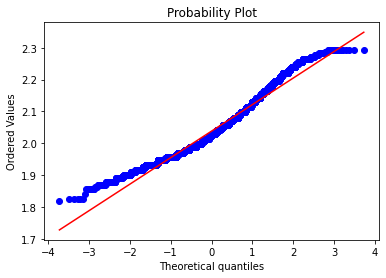

In [91]:
probplot(np.log(df.Price), plot=plt)
plt.show()

In [92]:
df.Price = np.log(df.Price)

In [93]:
droped_columns = ['Price', "Condo",'Negotiation Type', 'Property Type', 'Latitude', 'Longitude', 'City', 'New']
X = df.drop(columns=droped_columns)
y = df['Price']

In [94]:
# Vamos aplicar o OrdinarEnconder para a coluna categoria, que no caso é apenas o bairro
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

ordinal_encoder.fit(X[['District']].values)
X[['District']] =  ordinal_encoder.transform(X[['District']].values)

### PCA

In [95]:
ss = StandardScaler()
ss.fit(X)
X_standard = ss.transform(X)

pca = PCA(n_components=6)
pca.fit(X_standard)
print(f"PCA - Explained CumSum: {np.round(pca.explained_variance_ratio_.cumsum(), decimals=2)}")

PCA - Explained CumSum: [0.43 0.57 0.68 0.78 0.87 0.93]


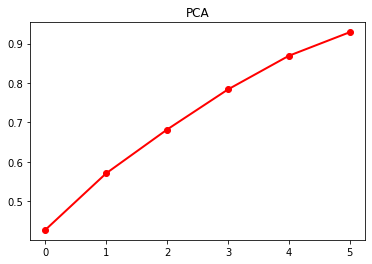

In [96]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'ro-', linewidth=2)
plt.title('PCA')
plt.show()

Escolhemos `n_components=6` para PCA

In [97]:
# Vamos criar nossa base de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

print("RMSE com OrdinalEnconder:") 
print(score_(X_train, X_test, y_train, y_test))

RMSE com OrdinalEnconder:
0.052832412849201975


In [98]:
df_pca=pd.DataFrame(pca.transform(X_train.values))

In [99]:
#Cuidado essa tarefa leva cerca de 73 minutos
grid_search = False
if grid_search:
    start=time.time()
    clf = GridSearchCV(XGBRegressor(), {'n_estimators': [100, 250, 700,1000],
    #                                        'criterion': ["squared_error", "absolute_error", "poisson"],
                                           'max_depth': [1,3,5],
                                            'learning_rate': [0.001, 0.2,0.3,0.5,0.7,0.9],
    #                                        'min_samples_split': [2, 5, 10],
    #                                        'min_samples_leaf': [2, 6, 10, 15],
                                            'subsample': [0.01,0.2,0.5,0.8],
                                            'colsample_bytree': [0.01,0.2,0.5,0.8],
                                           'n_jobs': [20],
                                            'random_state': [42],
                                                },
                      scoring='neg_root_mean_squared_error',
                      cv=5,
                      error_score='raise',
                      verbose=3)
    # clf.fit(label_X_train, y_train)
    clf.fit(df_pca, y_train)
    winsound.Beep(freq, duration*10)
    print(np.round(time.time()-start, 2))

In [100]:
if grid_search:
    clf.best_estimator_

Os melhores hiperparametros:

`XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=700, n_jobs=20,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)`

In [118]:
model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=np.nan,
             monotone_constraints='()', n_estimators=700, n_jobs=20,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [119]:
score_(X_train, X_test, y_train, y_test, model)

0.03637774414227613

In [120]:
pipe = Pipeline(steps=[
        ("normalizacao", StandardScaler()),
    ('PCA', PCA(n_components=6)),
    ('model', model)
])
scores = cross_val_score(pipe, X_train, y_train,
                          cv=5,
                          scoring='neg_mean_absolute_error',
                          error_score='raise')
print(-1 * scores)

[0.03632172 0.0385482  0.03642502 0.03648281 0.03640937]


In [121]:
pipe.fit(X_test.values, y_test)

Pipeline(steps=[('normalizacao', StandardScaler()),
                ('PCA', PCA(n_components=6)),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.8, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.2, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=5, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=700, n_jobs=20, num_parallel_tree=1,
                              predictor='auto', random_sta

In [122]:
predict = pipe.predict(X_test.values)

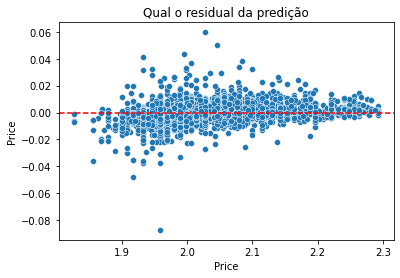

In [123]:
residual = y_test - predict
plt.title('Qual o residual da predição')
sns.scatterplot(x=y_test, y=residual)
plt.axhline(y=0, color='red', ls='--');

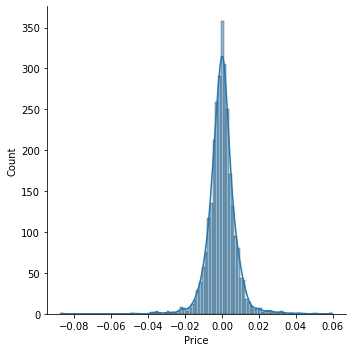

In [106]:
sns.displot(residual, bins=100, kde=True);

In [107]:
round(r2_score(y_test, predict),2)

0.99

Qual o nosso score?

In [108]:
test_district = test_sample['District']
test_sample[['District']] = ordinal_encoder.transform(test_sample[['District']].values)
test_sample_true = test_sample['Price']
test_sample.drop(columns=droped_columns,  inplace=True)
pipe.score(test_sample.values, np.log(test_sample_true))

0.6684557823285269

Qual o RMSE?

In [116]:
rmse(pipe.predict(test_sample.values), np.log(test_sample_true))

0.05150199009217395

Vamos salvar nossos modelos, para utilizar em nosso aplicativo.

In [110]:
from joblib import dump, load
dump(pipe, 'models\pipe_rfr.joblib')
dump(ordinal_encoder, 'models\ordinal_encoder.joblib')
dump(pca, 'models\pca.joblib')

['models\\pca.joblib']